Libraries

In [1]:
# importing required libraries
import pandas as pd
import numpy as np
import gurobipy as gp
import matplotlib.pyplot as plt
%matplotlib inline
from sklearn.cluster import KMeans
from sklearn.preprocessing import StandardScaler
import math


K-Means Clustering

In [2]:
def kcluster(csv):
    # read csv
    location=pd.read_csv(csv)
    scaler = StandardScaler()
    data_scaled = scaler.fit_transform(location)
    # k means using 10 clusters and k-means++ initialization
    kmeans = KMeans(n_clusters = 10, init='k-means++')
    kmeans.fit(data_scaled)
    return location, kmeans
    

# statistics of scaled data
#pd.DataFrame(data_scaled).describe()

Distance Function

In [3]:
def get_dist(x1,y1,x2,y2):
    return math.sqrt((x1-x2)**2 + (y1-y2)**2)

Set up Distance Matrix

In [4]:
# get (x,y) coordinates per cluster
def get_clusters(location, kmeans):
    clusters = [[(0,0)] for _ in range(10)] # init 10 clusters w/ distribution center attached
    for i in range(len(kmeans.labels_)):
        clusters[kmeans.labels_[i]].append(location.iloc[i])
    return clusters # let n be the number of points in cluster i, function will return 10 clusters of size n comprised of (x,y) sorted in cluster

In [5]:
# dist matrix
def make_array(n, clusters):
    # instead of making 501x501 dist matrix, we init an (N,N) matrix of the specific cluster whose TSP we're solving
    array = [[0 for _ in range(len(clusters[n]))] for _ in range(len(clusters[n]))]
    for i in range(len(clusters[n])):
        for j in range(len(clusters[n])):
            if i == j:
                array[i][j] = 1e6 # deincentivize city going to itself
            else:
                x1,y1 = clusters[n][i]
                x2,y2 = clusters[n][j]
                array[i][j] = get_dist(x1,y1,x2,y2)
    return array


Get distance of a random path

In [6]:
def get_dist_path(path): # can be used for clusters as well when simulated annealing
    dist = 0 
    for i in range(1, len(path)):
        x1,y1 = path[i-1][0], path[i-1][1]
        x2,y2 = path[i][0], path[i][1]
        dist += get_dist(x1,y1,x2,y2)
    # add dist from last node to beginning node
    dist += get_dist(path[-1][0],path[-1][1],path[0][0],path[0][1])
    return dist

Get distance of the random clusters

In [7]:
def get_dist_cluster(random_clusters):
    dist = 0
    for i in random_clusters:
        dist += get_dist_path(i)
    return dist

Get square of a random cluster

In [8]:
def get_square_cluster(random_clusters):
    dist = 0
    for i in random_clusters:
        dist += get_dist_path(i)**2
    return dist

Putting it all together for TSP and Simulated Annealing

In [9]:
def get_prereqs(csv):
    location, kmeans = kcluster(csv)
    clusters = get_clusters(location, kmeans)
    cluster_map = pd.DataFrame()
    cluster_map['data_index'] = location.index.values
    cluster_map['cluster'] = kmeans.labels_

    return clusters, location, kmeans, cluster_map

TSP Template

In [10]:
def tsp(n, clusters):
    # distance matrix
    array = make_array(n, clusters)
    N = len(array)
    # gurobi
    model = gp.Model()
    d = model.addMVar((N,N), vtype = 'B')
    u = model.addMVar(N)
    # obj
    model.setObjective(gp.quicksum(d[i,j]*array[i][j] for i in range(N) for j in range(N)))
    # cons
    # leave each city once
    leave = model.addConstrs((gp.quicksum(d[i,j] for i in range(N))==1) for j in range(N))
    # enter each city once
    enter = model.addConstrs((gp.quicksum(d[i,j] for j in range(N))==1) for i in range(N))
    # u constraints
    ucons = model.addConstrs((u[i] - u[j] + N*d[i,j] <= (N-1)) for i in range(1,N) for j in range(1,N) if i != j)
    # get ans
    model.Params.OutputFlag = 0 # tell gurobi to shut up!!
    model.optimize()
    return model.objVal

Reverse Package Option

In [11]:
def reverse_path(path):
    start, end = np.random.choice(len(path), 2, replace = False)
    if start < end:
        change_path = np.array(path[start:end+1])[::-1]
        new_path = np.concatenate((path[:start],change_path,path[end+1:]))
    else:
        change_path = np.concatenate((path[start:],path[:end+1]))[::-1]
        new_path = np.concatenate((change_path,path[end+1:start]))

    return new_path


Transport Package Option

In [12]:
def transport_path(path):
    start, end = np.random.choice(len(path), 2, replace = False)
    if start < end:
        splice = np.array(path[start:end+1])
        closed = np.concatenate((path[:start],path[end+1:]))
    else:
        splice = np.concatenate((path[start:],path[:end+1]))
        closed = np.array(path[end+1:start])

    N = len(closed)
    if not N:
        new_path = path
    else:
        choice = np.random.choice(N,1)[0]
        new_path = np.concatenate((closed[0:(choice+1)],splice,closed[(choice+1):]), axis = 0)#,closed_path[(paste+1):])
    
    return new_path

Get Random Clusters

In [13]:
def get_random_clusters(n, random_path):
    random_clusters = np.array_split(random_path, n)
    for i in range(len(random_clusters)):
        random_clusters[i] = np.concatenate(([(0,0)], random_clusters[i])) # add distribution to clusters
    return random_clusters

Switch Package Option

In [14]:
def switch_path(random_clusters):
    pick_truck, switch_truck = np.random.choice(len(random_clusters), 2, replace = False)
    pick_package = switch_package = (0,0)

    # can't pick the distribution center
    while not(all(pick_package)) and not(all(switch_package)):
        pick_package = np.random.choice(len(random_clusters[pick_truck]), 1)
        switch_package = np.random.choice(len(random_clusters[switch_truck]), 1)
    
    # change cluster that had package transferred
    package = random_clusters[pick_truck][pick_package]
    # remove package from current route
    random_clusters[pick_truck] = np.delete(random_clusters[pick_truck], pick_package, axis = 0)
    # move package to truck and specified slot
    random_clusters[switch_truck] = np.insert(random_clusters[switch_truck], switch_package, package, axis = 0)
    return random_clusters

Evaluate Path

In [15]:
def eval_path_cluster(path, new_path, probability, probability_to_accept):
    # init distances
    best_dist = get_dist_path(path)
    curr_dist = get_dist_path(new_path)

    # if we get a worse path
    if curr_dist > best_dist:
        option = np.random.uniform(0,1,1)
        # if we hit the prob to accept or lower we accept the worse path, else we keep (do nothing)
        if option <= probability_to_accept:
            # lower the probability to accept
            probability_to_accept = probability/math.exp(curr_dist-best_dist)
            best_dist = curr_dist
            path = new_path
    # we got a better path so we take
    else:
        best_dist = curr_dist
        path = new_path

    return best_dist, path, probability_to_accept

Evaluate Path Square

In [16]:
def eval_path_square(random_clusters, new_clusters, probability, probability_to_accept):
    # init distances
    best_dist = get_dist_cluster(random_clusters)
    curr_dist = get_dist_cluster(new_clusters)
    
    # init squares
    best_square = get_square_cluster(random_clusters)
    curr_square = get_square_cluster(new_clusters)

    # if we get a worse path
    if curr_square > best_square:
        option = np.random.uniform(0,1,1)
        # if we hit the prob to accept or lower we accept the worse path, else we keep (do nothing)
        if option <= probability_to_accept:
            # lower the probability to accept
            probability_to_accept = probability/math.exp(curr_dist-best_dist)
            random_clusters = new_clusters
    # we got a better path so we take
    else:
        random_clusters = new_clusters

    return random_clusters, probability_to_accept

2-Step Simulated Annealing Function

In [17]:
def simulated_annealing_2_step(n, path):
    # let n be the number of loops
    # let path be a randomized path we initiated
    
    # init probability
    probability = .95
    probability_to_accept = .05
    
    
    # best dist - inited with our randomized path
    best_dist = get_dist_path(path)

    # 2 step simulated annealing
    for _ in range(n):
        option = np.random.uniform(0,1,1)
        # reverse option
        if option <= .5:
            new_path = reverse_path(path)
        # transport option
        else:
            new_path = transport_path(path)
            
        # change best_dist accordingly
        best_dist, path, probability_to_accept = eval_path_cluster(path, new_path, probability, probability_to_accept)
        # change init probability
        probability *= .99
        
        
    
    return best_dist

            

3-Step Annealing Function

In [18]:
def simulated_annealing_3_step(n, random_clusters):
    # let n be the number of loops
    
    # init probability
    probability = .95
    probability_to_accept = .05


    # 3 step simulated annealing
    for _ in range(n):
        option = np.random.uniform(0,1,1)
        cluster = np.random.choice(len(random_clusters),1)[0]
        original = random_clusters.copy()
    
        # reverse option
        if option <= .495:
            random_clusters[cluster] = reverse_path(random_clusters[cluster])
        # transport option
        elif option <= .99:
            random_clusters[cluster] = transport_path(random_clusters[cluster])
        # switch option
        else:
            random_clusters = switch_path(random_clusters)

        # change best square accordingly
        random_clusters, probability_to_accept = eval_path_square(original, random_clusters, probability, probability_to_accept)
        # change init probability
        probability *= .99
    
    # get dist after minimizing squares
    best_dist = get_dist_cluster(random_clusters)
    return best_dist, [len(i) for i in random_clusters], [get_dist_path(i) for i in random_clusters]

Cost Function

In [19]:
def get_cost(dist, miles_per_truck):
    cost_per_mile = dist
    additional_pay = 300*len(miles_per_truck)
    overtime = total_cost = 0
    
    # get overtime
    for i in miles_per_truck:
        average = sum(miles_per_truck)/len(miles_per_truck)
        overtime_threshold = average*1.1
        if i >= overtime_threshold:
            overtime += (i-average)*1.5
    
    total_cost = cost_per_mile + additional_pay + overtime
    return cost_per_mile, additional_pay, overtime, total_cost
    

Question 1 - Sole Clustering

In [20]:
# get prereqs for problems
clusters, location1, kmeans, cluster_map = get_prereqs("locations1.csv")

/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/sklearn/cluster/_kmeans.py:1416: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)


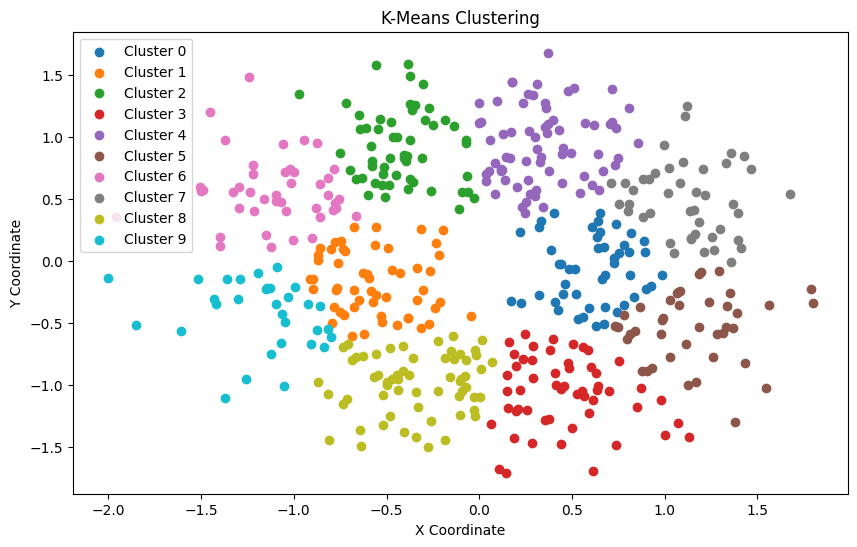

In [21]:
# Get the cluster labels assigned by k-means
cluster_labels = kmeans.labels_

# Get the cluster centers
cluster_centers = kmeans.cluster_centers_

# Plot the data points with each cluster in a different color
plt.figure(figsize=(10, 6))

for i in range(10):
    plt.scatter(location1.iloc[cluster_labels == i, 0], location1.iloc[cluster_labels == i, 1], label=f'Cluster {i}')


plt.title("K-Means Clustering")
plt.xlabel("X Coordinate")
plt.ylabel("Y Coordinate")
plt.legend()
plt.show()

Question 1 - TSP

In [22]:
def q1_tsp(clusters):
    total = 0
    for i in range(10):
        total += tsp(i, clusters)
    return total

dist = q1_tsp(clusters)
dist # 65.35914774493456

Set parameter Username
Academic license - for non-commercial use only - expires 2024-09-18


65.68321844161055

Question 1 - 2 Step Simluated Annealing

In [ ]:
def q1_2_step():
    
    random_path = np.concatenate(([(0,0)],[location1.iloc[i] for i in range(location1.shape[0])]))
    np.random.shuffle(random_path)

    dist = simulated_annealing_2_step(int(4e5), random_path)
    return dist

dist = q1_2_step()
dist # 57.37433203209507

Question 1 - 3 Step Annealing

In [ ]:
def q1_3_step():
    random_path = np.array([location1.iloc[i] for i in range(location1.shape[0])])
    np.random.shuffle(random_path)
    random_clusters = get_random_clusters(10,random_path)
    dist, package_per_truck, miles_per_truck = simulated_annealing_3_step(int(1e5), random_clusters)
    return dist, package_per_truck

dist, package_per_truck = q1_3_step()
dist, package_per_truck

Question 2 Factoring in Costs

In [ ]:
def costs_3_step():
    # init random path
    random_path = np.array([location1.iloc[i] for i in range(location1.shape[0])])
    np.random.shuffle(random_path)
    
    for i in range(2,11):
        # init random clusters
        if i == 1:
            random_clusters = random_path
        else:
            random_clusters = list(get_random_clusters(i, random_path))
        dist, package_per_truck, miles_per_truck = simulated_annealing_3_step(int(1e5), random_clusters)
        cost_per_package, additional_pay, overtime, total_cost = get_cost(dist, miles_per_truck)
        print(f'distance: {dist} | number of packages delivered:" {package_per_truck} | miles per truck: {miles_per_truck} | cost per mile: {cost_per_package} | additional pay: {additional_pay} | overtime: {overtime} | total cost: {total_cost}')

costs_3_step()

Question 3 - Location 2 TSP From Scratch

In [ ]:
clusters, location2, kmeans, cluster_map = get_prereqs("locations2.csv")

In [ ]:
def q3_tsp(clusters):
    total = 0
    for i in range(10):
        total += tsp(i, clusters)
    return total

dist = q3_tsp(clusters)
dist # 65.35914774493456

In [ ]:
# Get the cluster labels assigned by k-means
cluster_labels = kmeans.labels_

# Get the cluster centers
cluster_centers = kmeans.cluster_centers_

# Plot the data points with each cluster in a different color
plt.figure(figsize=(10, 6))

for i in range(10):
    plt.scatter(location2.iloc[cluster_labels == i, 0], location2.iloc[cluster_labels == i, 1], label=f'Cluster {i}')


plt.title("K-Means Clustering")
plt.xlabel("X Coordinate")
plt.ylabel("Y Coordinate")
plt.legend()
plt.show()

In [ ]:
def q3_2_step():
    random_path = np.concatenate(([(0,0)],[location2.iloc[i] for i in range(location2.shape[0])]))
    np.random.shuffle(random_path)

    dist = simulated_annealing_2_step(int(4e5), random_path)
    return dist

q3_2_step()


Question 3 - Using Yesterday's Clustering

In [ ]:
# get prereqs
clusters, location, kmeans, cluster_map = get_prereqs("locations1.csv")
kmeans.labels_

In [ ]:
df1 = pd.read_csv('locations1.csv')
df2 = pd.read_csv('locations2.csv')

def calculate_distance(df1, df2):
    distances = []

    for index1, row1 in df1.iterrows():
        for index2, row2 in df2.iterrows():
            x1, y1 = row1['x'], row1['y']
            x2, y2 = row2['x'], row2['y']
            distance = math.sqrt((x1 - x2) ** 2 + (y1 - y2) ** 2)
            distances.append({'df2_x': x2, 'df2_y': y2, 'df1_x': x1, 'df1_y': y1, 'distance': distance})

    result_df = pd.DataFrame(distances)
    result_df['Loc2_ID'] = result_df.groupby(['df2_x', 'df2_y']).ngroup().apply(lambda x: f'{x:03d}')
    result_df['Loc1_ID'] = result_df.groupby(['df1_x', 'df1_y']).ngroup().apply(lambda x: f'{x:03d}')

    return result_df

result = calculate_distance(df1, df2)
result['df2_coordinates'] = result.apply(lambda row: f"({round(row['df2_x'], 4)},{round(row['df2_y'], 4)})", axis=1)
result['df1_coordinates'] = result.apply(lambda row: f"({round(row['df1_x'], 4)},{round(row['df1_y'], 4)})", axis=1)
result = result.drop(columns=['df2_x', 'df2_y', 'df1_x', 'df1_y'])

result.sort_values(by='distance')
min_distances = result.sort_values(by='distance')
smallest_distances_df1 = min_distances.groupby('Loc2_ID').first().reset_index()
smallest_df2_for_df1 = smallest_distances_df1[['Loc2_ID', 'Loc1_ID']]
smallest_df2_for_df1_array = smallest_df2_for_df1.values

In [ ]:
# get prereqs for problems
# get (x,y) coordinates per cluster
def get_clusters(location, kmeans, map):
    clusters = [[(0,0)] for _ in range(10)] # init 10 clusters w/ distribution center attached
    for i in range(location.shape[0]):
        clusters[kmeans.labels_[int(map[i][1])]].append(location.iloc[i])
    return clusters # let n be the number of points in cluster i, function will return 10 clusters of size n comprised of (x,y) sorted in cluster

locations2 = pd.read_csv("locations2.csv")
clusters_2 = get_clusters(locations2, kmeans, smallest_df2_for_df1_array)


In [ ]:
def q3_3_step(clusters):
    dist, package_per_truck, miles_per_truck = simulated_annealing_3_step(int(1e5), clusters)
    cost_per_package, additional_pay, overtime, total_cost = get_cost(dist, miles_per_truck)
    print(f'distance: {dist} | number of packages delivered:" {package_per_truck} | miles per truck: {miles_per_truck} | cost per mile: {cost_per_package} | additional pay: {additional_pay} | overtime: {overtime} | total cost: {total_cost}')
    return dist, package_per_truck, miles_per_truck

dist, package_per_truck, miles_per_truck = q3_3_step(clusters_2)
dist, package_per_truck, miles_per_truck